<a href="https://colab.research.google.com/github/patrickmineault/xcorr-notebooks/blob/master/A_linear_normalizing_flow_model_for_neural_ICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#LICE vs. NICE

[I previously showed how linear latent variable models, including PCA and NMF](https://github.com/patrickmineault/xcorr-notebooks/blob/master/PCA_through_gradient_descent.ipynb), can be implemented as maximum likelihood under certain generative models. These models focus on modeling the data with a generative model, $g: z \to x$ as opposed to modeling the latents via a function $f: x \to z$. One disadvantage of these models is they require an expensive inference step involving an optimization in order to find the latents, or require learning an amortized inference model. Here I present an alternative, where inference and sampling are easy.

NICE (nonlinear independent component estimation) seeks to find latent independent representations of complex datasets, similar in spirit to ICA. The idea behind [NICE](https://arxiv.org/abs/1410.8516) is to map datapoints via $z = f(x): \mathbb{R}^N \to \mathbb{R}^N$ where f is invertible and $p(z) = \prod_i p(z_i)$, where $p(z_i)$ is a fixed and known probability distribution. It's possible to directly optimize the likelihood of the latents (*not* the data), given the determinant of the Jacobian of $f$. The invertibility of the transformation $f$ and the need for a tractable Jacobian limits the transformations that can be learned. This leads Dinh et al. to consider partitioning latent representations into two subsets, cleverly setting up conditions on the DAG of the hidden variables to allow for more flexible representations.

Here, I consider a linear variant of NICE, which I will call LICE (clever, right?), which is similar to ICA. Instead of using the partitioning scheme of Dinh et al., I will the conceptually simpler $LU$ decomposition (mentioned in section 3.1 in the paper): $f$ will map $x \to LUx$, where $LU$ are lower and upper diagonal matrices, respectively. The determininant of the Jacobian of the transformation can be read off from the diagonals of the $L$ and $U$ matrices, making it simple to calculate. LU decompositions can express any square matrix, hence are precisely as powerful as a full rank transformation matrix (the underlying transformation in ICA). As for the fixed distribution, we'll choose something that has long tails to fit with ICA - let's use a t-distribution with 4 degrees of freedom.

Before we get started, let's create some sample data and showcase standard ICA ([reusing this example from sklearn](https://scikit-learn.org/stable/auto_examples/decomposition/plot_ica_blind_source_separation.html#sphx-glr-auto-examples-decomposition-plot-ica-blind-source-separation-py)).

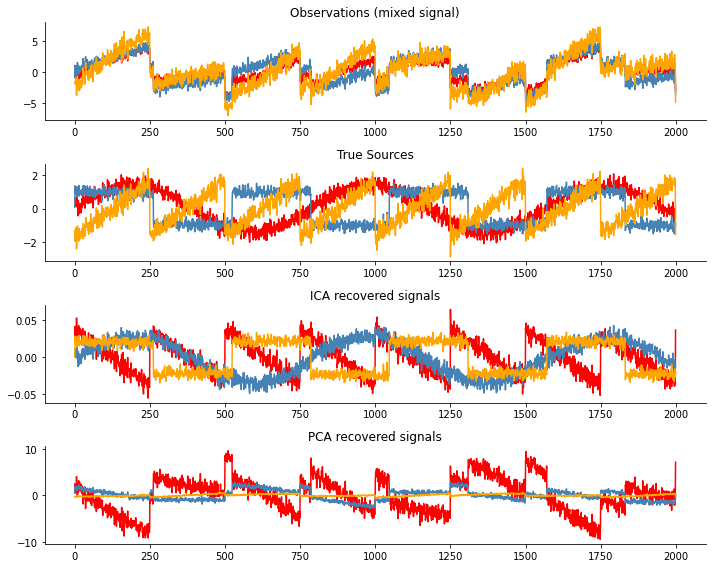

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

from sklearn.decomposition import FastICA, PCA

# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

# #############################################################################
# Plot results

plt.figure(figsize=(10, 8))

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
sns.despine()

Let's do it the LICE way instead.

In [2]:
# @title Standard PyTorch imports and training loop
import torch
from torch import optim
from torch import nn
import torch.nn.functional as F

quiet = False
def train(model, train_loader, optimizer, epoch, grad_clip=None):
  model.train()
  
  train_losses = []
  for x in train_loader:
    x = x.cuda().contiguous()
    loss = model.loss(x)
    optimizer.zero_grad()
    loss.backward()
    if grad_clip:
      torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()
    train_losses.append(loss.item())
  return train_losses

def eval_loss(model, data_loader):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for x in data_loader:
      x = x.cuda().contiguous()
      loss = model.loss(x)
      total_loss += loss * x.shape[0]
    avg_loss = total_loss / len(data_loader.dataset)

  return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
  epochs, lr, print_freq = train_args['epochs'], train_args['lr'], train_args.get('print_freq', 1)
  grad_clip = train_args.get('grad_clip', None)
  optimizer = optim.Adam(model.parameters(), lr=lr)

  train_losses = []
  test_losses = [eval_loss(model, test_loader)]
  for epoch in range(epochs):
    model.train()
    train_losses.extend(train(model, train_loader, optimizer, epoch, grad_clip))
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)
    if epoch % print_freq == 0:
      print(f'Epoch {epoch}, Test loss {test_loss:.4f}')

  return train_losses, test_losses

Epoch 0, Test loss 134.0213
Epoch 10, Test loss 74.4982
Epoch 20, Test loss 72.3333


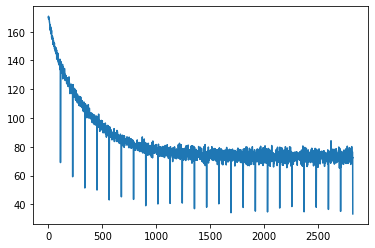

In [3]:
class LUFlow(nn.Module):
  def __init__(self, N):
    super().__init__()
    self.U = nn.Parameter(torch.randn(N, N) / np.sqrt(N))
    self.L = nn.Parameter(torch.randn(N, N) / np.sqrt(N))
    self.UL = None
    self.dist = torch.distributions.StudentT(2)

  def forward(self, X):
    return (X @ torch.tril(self.L)) @ torch.triu(self.U)

  def compute_inverse(self):
    # Note: does not scale well to large ICA problems.
    self.UL = torch.inv(torch.tril(self.L) @ torch.triu(self.U))

  def logdet(self, X):
    # The determinant of lower and upper diagonal matrices is very easy to compute.
    return X.shape[0] *(torch.log(abs(torch.diag(self.U))) +
                        torch.log(abs(torch.diag(self.L)))).sum()

  def loss(self, X):
    z = self(X)

    # Compute the log likelihood of z
    prob = -self.dist.log_prob(z).sum()

    # And the log determininant
    logdetX = -self.logdet(X).sum()
    
    return prob + logdetX

  def sample(self, M):
    if self.UL is None:
      self.compute_inverse()
    z = dist.sample([M, self.U.shape[0]]).to(device='cuda')
    return self.UL @ z

model = LUFlow(3)
model.to(device='cuda')


idx = (np.arange(X.shape[0]) % 10) == 0

train_loader = torch.utils.data.DataLoader(H[~idx, :].astype(np.float32), batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(H[idx, :].astype(np.float32), batch_size=16, shuffle=True)

train_evals, test_evals = train_epochs(model, train_loader, test_loader, {'epochs': 25, 'lr': 1e-3, 'print_freq': 10})
plt.plot(train_evals)

In [4]:
Z = model(torch.tensor(H).to(device='cuda', dtype=torch.float)).detach().cpu().numpy()

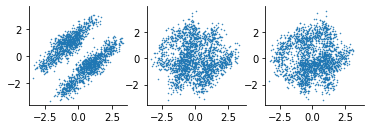

In [5]:
delta = 0
for i in range(3):
  for j in range(i + 1, 3):
    plt.subplot(131 + delta)
    plt.plot(Z[:, i], Z[:, j], '.', markersize=1)
    plt.axis('square')
    sns.despine()
    delta += 1

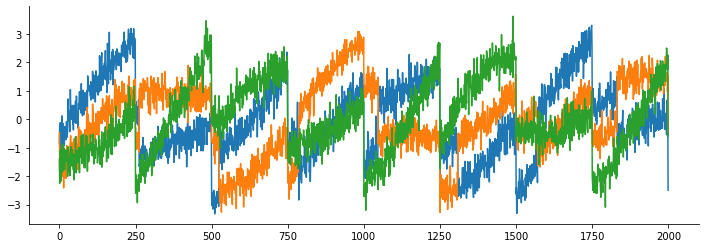

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(Z)
sns.despine()

This doesn't demix the components. What's going on?

# Univariate transforms: LucyFlow

This works poorly - it doesn't demix the components. One issue is that the assumed distribution for the latents is fixed at a t distribution - yet, the distributions are actually closer to a bimodal distribution for one variable, a uniform distribution for a second, and a circular distribution for the third. What we need is a univariate nonlinearity that can transform an arbitrary distribution into another, such that our weird bimodel and circular distribution get mapped to a standard shape via a learned nonlinearity. 

Once again, the transformation must be invertible, hence we use the cumulative distribution function of a mixture of logistic distributions. Since a CDF's support is $[0, 1]$, we'll use a product of uniform distributions to model the latents. Since the transformation is an LU decomposition followed by Cdfs, let's call it Lucyflow.

In [7]:
class CumMixOfLogistics(nn.Module):
  def __init__(self, N=1, n=4):
    """
    n: number of components per mixture components
    N: number of parallel nonlinearities
    """
    super().__init__()
    self.log_slopes = nn.Parameter(torch.randn(1, N, n)+1)
    self.log_pi = nn.Parameter(torch.randn(1, N, n))
    self.centers = nn.Parameter(torch.randn(1, N, n))
    
    self.N = N
    self.n = n

  def forward(self, X):
    pi = torch.softmax(self.log_pi, dim=2)
    slopes = torch.exp(self.log_slopes)
    return ((torch.sigmoid(slopes * (X.view(X.shape[0], X.shape[1], 1) - self.centers)) * pi).sum(axis=2))

  def logdet(self, X):
    pi = torch.softmax(self.log_pi, dim=2)
    slopes = torch.exp(self.log_slopes)
    y = (torch.sigmoid(slopes * (X.view(X.shape[0], X.shape[1], 1) - self.centers)))
    return torch.log((y * (1 - y) * slopes * pi).sum(axis=2)).sum()

# One annoying thing about these models is I haven't figured a way to propagate
# the gradient through the log of the jacobian, so we have to check the gradients 
# the log of Jacobian manually.

model = CumMixOfLogistics(3, 4)
model = model.to(device='cuda')

HH = torch.tensor(H).to(device='cuda', dtype=torch.float)
J0 = torch.log(abs(torch.det(torch.autograd.functional.jacobian(lambda x: model(x), HH[0:1, :]).squeeze()))).detach().cpu().numpy()
J1 = model.logdet(HH[0:1, :]).detach().cpu().numpy()

np.testing.assert_allclose(J0, J1)

Epoch 0, Test loss 237.4059
Epoch 20, Test loss 87.5146
Epoch 40, Test loss 80.3798
Epoch 60, Test loss 79.4013
Epoch 80, Test loss 79.4330


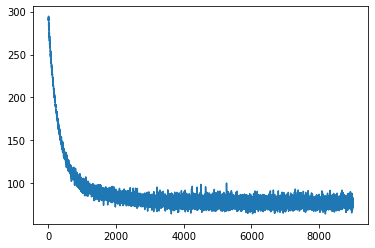

In [8]:
class LucyFlow(nn.Module):
  def __init__(self, N):
    super().__init__()
    self.U = nn.Parameter(torch.randn(N, N) / np.sqrt(N))
    self.L = nn.Parameter(torch.randn(N, N) / np.sqrt(N))
    self.UL = None
    self.dist = torch.distributions.Uniform(torch.tensor(0.0).to(device='cuda'), 
                                            torch.tensor(1.0).to(device='cuda'))
    self.nl = CumMixOfLogistics(N, 4)

  def forward(self, X):
    return self.nl((X @ torch.tril(self.L)) @ torch.triu(self.U))

  def forward_lin(self, X):
    return (X @ torch.tril(self.L)) @ torch.triu(self.U)

  def logdet(self, X):
    # The determinant of lower and upper diagonal matrices is very easy to compute.
    return (X.shape[0] * (torch.log(abs(torch.diag(self.U))) +
                          torch.log(abs(torch.diag(self.L)))).sum() +
            self.nl.logdet((X @ torch.tril(self.L)) @ torch.triu(self.U)))

  def loss(self, X):
    z = self(X)

    # Compute the log likelihood of z
    prob = -self.dist.log_prob(z).sum()

    # And the log determininant of the Jacobian.
    logdetX = -self.logdet(X).sum()
    
    return prob + logdetX

model = LucyFlow(3)
model.to(device='cuda')
HH = torch.tensor(H).to(device='cuda', dtype=torch.float)
J0 = torch.log(abs(torch.det(torch.autograd.functional.jacobian(lambda x: model(x), HH[0:1, :]).squeeze()))).detach().cpu().numpy()
J1 = model.logdet(HH[0:1, :]).detach().cpu().numpy()

np.testing.assert_allclose(J0, J1, rtol=1e-5)

idx = (np.arange(X.shape[0]) % 10) == 0

train_loader = torch.utils.data.DataLoader(X[~idx, :].astype(np.float32), batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(X[idx, :].astype(np.float32), batch_size=20, shuffle=True)

train_evals, test_evals = train_epochs(model, train_loader, test_loader, {'epochs': 100, 'lr': 1e-3, 'print_freq': 20})
plt.plot(train_evals)

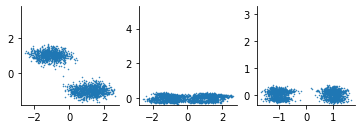

In [9]:
Z = model.forward_lin(torch.tensor(X).to(device='cuda', dtype=torch.float)).detach().cpu().numpy()

delta = 0
for i in range(3):
  for j in range(i + 1, 3):
    plt.subplot(131 + delta)
    plt.plot(Z[:, i], Z[:, j], '.', markersize=1)
    plt.axis('square')
    sns.despine()
    delta += 1

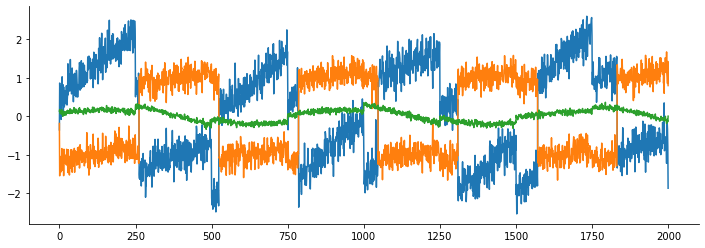

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(Z)
sns.despine()

It's generally pretty easy to find the most bimodal component this way (square wave) . However, the hit rate on the other components is pretty low - about 1/3 of the time, one finds the right components - other times, it gets stuck in local minima. NBD - we can do multiple restarts to find a more favorable configuration.

Epoch 0, Test loss 286.9839
Epoch 20, Test loss 87.2393
Epoch 40, Test loss 80.5195
Epoch 60, Test loss 74.3585
Epoch 80, Test loss 71.6590
Epoch 0, Test loss 213.1845
Epoch 20, Test loss 84.6258
Epoch 40, Test loss 65.6630
Epoch 60, Test loss 65.2261
Epoch 80, Test loss 64.8018
Epoch 0, Test loss 221.5940
Epoch 20, Test loss 72.3526
Epoch 40, Test loss 69.8172
Epoch 60, Test loss 67.8637
Epoch 80, Test loss 65.4256
Epoch 0, Test loss 218.8366
Epoch 20, Test loss 87.5313
Epoch 40, Test loss 72.6486
Epoch 60, Test loss 70.0821
Epoch 80, Test loss 68.3447
Epoch 0, Test loss 262.7703
Epoch 20, Test loss 71.0692
Epoch 40, Test loss 66.6613
Epoch 60, Test loss 65.8285
Epoch 80, Test loss 65.3224


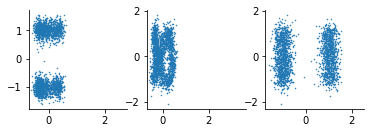

In [12]:
best_eval = np.inf
for i in range(5):
  model = LucyFlow(3)
  model.to(device='cuda')
  train_evals, test_evals = train_epochs(model, train_loader, test_loader, {'epochs': 100, 'lr': 1e-3, 'print_freq': 20})
  if test_evals[-1] < best_eval:
    best_model = model
    best_eval = test_evals[-1]

model = best_model

Z = model.forward_lin(torch.tensor(X).to(device='cuda', dtype=torch.float)).detach().cpu().numpy()

delta = 0
for i in range(3):
  for j in range(i + 1, 3):
    plt.subplot(131 + delta)
    plt.plot(Z[:, i], Z[:, j], '.', markersize=1)
    plt.axis('square')
    sns.despine()
    delta += 1

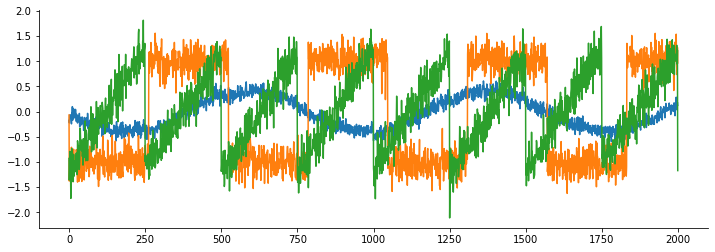

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(Z)
sns.despine()

It's interesting (though perhaps not practical!) that normalizing flow models like NICE can be related to classical algorithms like ICA. In science, we often want to restrict latent variable models based off of certain characteristics - the distribution of the latents or the components. Between PCA, ICA, NMF on the one side, and NICE, realNVP and VAEs on the other, there is a wide, unexplored world of highly structured nonlinear latent variable models, some of which may be useful.